In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.tabular import *

# Rossmann

## Data preparation

To create the feature-engineered train_clean and test_clean from the Kaggle competition data, run `rossman_data_clean.ipynb`. One important step that deals with time series is this:

```python
add_datepart(train, "Date", drop=False)
add_datepart(test, "Date", drop=False)
```

In [4]:
path = Config().data_path()/'rossmann'
train_df = pd.read_pickle(path/'train_clean')

In [5]:
train_df.head().T

,0,1,2,3,4
index,0,1,2,3,4
Store,1,2,3,4,5
DayOfWeek,5,5,5,5,5
Date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
Sales,5263,6064,8314,13995,4822
...,...,...,...,...,...
StateHoliday_bw,0,0,0,0,0
Promo_bw,5,5,5,5,5
SchoolHoliday_fw,7,1,5,1,1
StateHoliday_fw,0,0,0,0,0


In [6]:
n = len(train_df); n

844338

### Experimenting with a sample

In [7]:
idx = np.random.permutation(range(n))[:2000]
idx.sort()
small_train_df = train_df.iloc[idx[:1000]]
small_test_df = train_df.iloc[idx[1000:]]
small_cont_vars = ['CompetitionDistance', 'Mean_Humidity']
small_cat_vars =  ['Store', 'DayOfWeek', 'PromoInterval']
small_train_df = small_train_df[small_cat_vars + small_cont_vars + ['Sales']]
small_test_df = small_test_df[small_cat_vars + small_cont_vars + ['Sales']]

In [8]:
small_train_df.head()

,Store,DayOfWeek,PromoInterval,CompetitionDistance,Mean_Humidity,Sales
843,845,5,"Jan,Apr,Jul,Oct",7860.0,61,5151
1282,170,4,"Jan,Apr,Jul,Oct",1070.0,73,4771
1448,337,4,"Feb,May,Aug,Nov",10600.0,56,6031
3205,982,3,NaN,21930.0,55,9492
3259,1036,3,"Jan,Apr,Jul,Oct",9560.0,67,5252


In [9]:
small_test_df.head()

,Store,DayOfWeek,PromoInterval,CompetitionDistance,Mean_Humidity,Sales
421176,380,2,"Mar,Jun,Sept,Dec",2240.0,47,18900
421271,475,2,NaN,140.0,47,7955
421309,513,2,NaN,400.0,72,22622
421645,850,2,"Jan,Apr,Jul,Oct",1120.0,47,12490
421650,855,2,"Feb,May,Aug,Nov",3440.0,55,7679


In [10]:
categorify = Categorify(small_cat_vars, small_cont_vars)
categorify(small_train_df)
categorify(small_test_df, test=True)

In [11]:
small_test_df.head()

,Store,DayOfWeek,PromoInterval,CompetitionDistance,Mean_Humidity,Sales
421176,380,2,"Mar,Jun,Sept,Dec",2240.0,47,18900
421271,475,2,NaN,140.0,47,7955
421309,513,2,NaN,400.0,72,22622
421645,850,2,"Jan,Apr,Jul,Oct",1120.0,47,12490
421650,NaN,2,"Feb,May,Aug,Nov",3440.0,55,7679


In [12]:
small_train_df.PromoInterval.cat.categories

Index(['Feb,May,Aug,Nov', 'Jan,Apr,Jul,Oct', 'Mar,Jun,Sept,Dec'], dtype='object')

In [13]:
small_train_df['PromoInterval'].cat.codes[:5]

843     1
1282    1
1448    0
3205   -1
3259    1
dtype: int8

In [14]:
fill_missing = FillMissing(small_cat_vars, small_cont_vars)
fill_missing(small_train_df)
fill_missing(small_test_df, test=True)

In [15]:
small_train_df[small_train_df['CompetitionDistance_na'] == True]

,Store,DayOfWeek,PromoInterval,CompetitionDistance,Mean_Humidity,Sales,CompetitionDistance_na
56671,291,2,NaN,2290.0,61,9897,True
127398,291,6,NaN,2290.0,94,4753,True


### Preparing full data set

In [16]:
train_df = pd.read_pickle(path/'train_clean')
test_df = pd.read_pickle(path/'test_clean')

In [17]:
len(train_df),len(test_df)

(844338, 41088)

In [18]:
procs=[FillMissing, Categorify, Normalize]

In [19]:
cat_vars = ['Store', 'DayOfWeek', 'Year', 'Month', 'Day', 'StateHoliday', 'CompetitionMonthsOpen',
    'Promo2Weeks', 'StoreType', 'Assortment', 'PromoInterval', 'CompetitionOpenSinceYear', 'Promo2SinceYear',
    'State', 'Week', 'Events', 'Promo_fw', 'Promo_bw', 'StateHoliday_fw', 'StateHoliday_bw',
    'SchoolHoliday_fw', 'SchoolHoliday_bw']

cont_vars = ['CompetitionDistance', 'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC',
   'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 'Max_Wind_SpeedKm_h', 
   'Mean_Wind_SpeedKm_h', 'CloudCover', 'trend', 'trend_DE',
   'AfterStateHoliday', 'BeforeStateHoliday', 'Promo', 'SchoolHoliday']

In [20]:
dep_var = 'Sales'
df = train_df[cat_vars + cont_vars + [dep_var,'Date']].copy()

In [21]:
test_df['Date'].min(), test_df['Date'].max()

(Timestamp('2015-08-01 00:00:00'), Timestamp('2015-09-17 00:00:00'))

In [23]:
cut = train_df['Date'][(train_df['Date'] == train_df['Date'][len(test_df)])].index.max()
cut

41395

In [24]:
valid_idx = range(cut)

In [25]:
df[dep_var].head()

0     5263
1     6064
2     8314
3    13995
4     4822
Name: Sales, dtype: int64

In [26]:
data = (TabularList.from_df(df, path=path, cat_names=cat_vars, cont_names=cont_vars, procs=procs,)
                .split_by_idx(valid_idx)
                .label_from_df(cols=dep_var, label_cls=FloatList, log=True)
                .add_test(TabularList.from_df(test_df, path=path, cat_names=cat_vars, cont_names=cont_vars))
                .databunch())

In [27]:
doc(FloatList)

class FloatList [source] [test] FloatList ( items : Iterator [ T_co ], log : bool = False , classes : Collection [ T_co ]= None , ** kwargs ) :: ItemList 
 
 × No tests found for FloatList . To contribute a test please refer to this guide and this discussion . ItemList suitable for storing the floats in items for regression. Will add a log if this flag is True . 
 Show in docs

## Model

In [28]:
max_log_y = np.log(np.max(train_df['Sales'])*1.2)
y_range = torch.tensor([0, max_log_y], device=defaults.device)

In [35]:
learn = tabular_learner(data, layers=[1000,500], ps=[0.001,0.01], emb_drop=0.04, 
                        y_range=y_range, metrics=exp_rmspe)

In [36]:
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(1116, 81)
    (1): Embedding(8, 5)
    (2): Embedding(4, 3)
    (3): Embedding(13, 7)
    (4): Embedding(32, 11)
    (5): Embedding(3, 3)
    (6): Embedding(26, 10)
    (7): Embedding(27, 10)
    (8): Embedding(5, 4)
    (9): Embedding(4, 3)
    (10): Embedding(4, 3)
    (11): Embedding(24, 9)
    (12): Embedding(9, 5)
    (13): Embedding(13, 7)
    (14): Embedding(53, 15)
    (15): Embedding(22, 9)
    (16): Embedding(7, 5)
    (17): Embedding(7, 5)
    (18): Embedding(4, 3)
    (19): Embedding(4, 3)
    (20): Embedding(9, 5)
    (21): Embedding(9, 5)
    (22): Embedding(3, 3)
    (23): Embedding(3, 3)
  )
  (emb_drop): Dropout(p=0.04, inplace=False)
  (bn_cont): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=233, out_features=1000, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_runn

In [37]:
len(data.train_ds.cont_names)

16

In [55]:
learn.lr_find()

epoch,train_loss,valid_loss,exp_rmspe,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


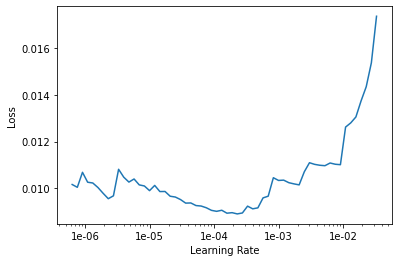

In [56]:
learn.recorder.plot()

In [58]:
learn.fit_one_cycle(2, 1e-4, wd=0.1)

epoch,train_loss,valid_loss,exp_rmspe,time
0,0.010841,0.012644,0.107596,02:53
1,0.009760,0.011936,0.105272,02:10


In [46]:
learn.save('1')

ValueError: zero-size array to reduction operation minimum which has no identity

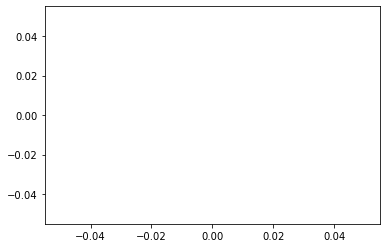

In [57]:
learn.recorder.plot_losses(skip_start=10000)

In [ ]:
learn.load('1');

In [ ]:
learn.fit_one_cycle(5, 3e-4)

epoch,train_loss,valid_loss,exp_rmspe
1,0.012223,0.014312,0.116988
2,0.012001,0.017789,0.117619
3,0.011402,0.035596,0.114396
4,0.010067,0.015125,0.113652
5,0.009148,0.031326,0.116344


In [ ]:
learn.fit_one_cycle(5, 3e-4)

epoch,train_loss,valid_loss,exp_rmspe
1,0.011840,0.013236,0.110483
2,0.010765,0.057664,0.129586
3,0.010101,0.042744,0.111584
4,0.008820,0.116893,0.135458
5,0.009144,0.017969,0.126323


(10th place in the competition was 0.108)

In [ ]:
test_preds=learn.get_preds(DatasetType.Test)
test_df["Sales"]=np.exp(test_preds[0].data).numpy().T[0]
test_df[["Id","Sales"]]=test_df[["Id","Sales"]].astype("int")
test_df[["Id","Sales"]].to_csv("rossmann_submission.csv",index=False)